In [30]:
from os import listdir
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from nltk.metrics.distance import edit_distance

In [2]:
MISSING = " "

# Load Data

## Charts

In [3]:
files = listdir("../chart")

dfs_chart = {}
for f in files:
    year = f.split("_")[0]
    month = f.split("_")[1].split(".")[0]

    if dfs_chart.get(year) is None:
        dfs_chart[year] = {}
        
    dfs_chart[year][month] = pd.read_csv("../chart/" + f)

In [4]:
dfs_chart["2006"]["Janvier"].head(3)

,Rank,Artist,Music
0,1,juanes,la camisa negra
1,2,madonna,hung up
2,3,johnny hallyday,mon plus beau noël


In [5]:
chart = []
for k1 in dfs_chart.keys():
    for k2 in dfs_chart[k1].keys():
        chart.append(dfs_chart[k1][k2])
chart = pd.concat(chart)
chart.drop(columns=["Rank"], inplace=True)
chart.drop_duplicates(inplace=True)

## Artists

In [6]:
artist = pd.read_csv("../artist.csv", index_col=0)

In [7]:
artist.head(3)

,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary
Artist,,,,,,,
franko,Franko (rappeur),"26 décembre 1987 (34 ans)douala, cameroun",NaN,NaN,NaN,NaN,"franko, de son vrai nom kinguè franck junior, ..."
axwell & ingrosso,Axwell Λ Ingrosso,NaN,NaN,NaN,NaN,NaN,"axwell λ ingrosso, prononcé axwell and ingross..."
silvercab,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis

In [8]:
artist.value_counts("Artist_wiki").sort_values() #Aucune page en wiki en double, ce qui est un bon signe !

Artist_wiki
LMC              1
24kGoldn         1
2NE1             1
3T               1
3rd Wish         1
                ..
Élodie Frégé     1
Étienne Daho     1
Yuksek           1
Yu-Gi-Oh!        1
MANUEL          11
Length: 1706, dtype: int64

In [9]:
np.round(artist["Artist_wiki"].isna().sum() / artist.shape[0], 2) # 24% des artistes n'ont pas de page en wiki

0.24

In [10]:
artist = artist[~artist["Artist_wiki"].isna()] #On ne garde que les artistes qui ont une page en wiki

In [11]:
#On recalcul les distances entre les noms d'artistes et les pages wikipédia pour vérifier
def calc_dist(artist, wiki):
    words = ["(chanteur)", "(chanteuse)", "(groupe)", "(rappeur)", "(rappeuse)", "(musicien)", "(chanteur français)", "(france)", "(producteur)", "(artiste)", "(groupe de musique)"]

    if any(w in wiki.lower() for w in words):
        dist = edit_distance(artist.lower().strip(), wiki.lower().split(" (")[0].strip())
        if dist/len(artist) < 0.4:
            return dist
    
    return edit_distance(artist.lower().strip(), wiki.lower().strip())

artist["distance"] = artist.apply(lambda x: calc_dist(x.name, x["Artist_wiki"]), axis=1)
artist["distance_norm"] = artist.apply(lambda x : x["distance"]/len(x.name), axis=1)

In [12]:
n = 0
artist.sort_values("distance_norm", ascending=False)[n*50:(n+1)*50] #Nos distances sont bonnes

,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary,distance,distance_norm
Artist,,,,,,,,,
glk,MANUEL,NaN,NaN,française,NaN,NaN,"Originaire de Bobigny, en Seine-Saint-Denis",6,2.000000
al. hy,MANUEL,15 novembre 1993,NaN,française,NaN,NaN,"15 novembre 1993 (Âge: 29 ans), Saint-Amand-le...",6,1.000000
1pliké140,MANUEL,1963,NaN,française,NaN,NaN,1PLIKÉ140 est un jeune rappeur français origin...,9,1.000000
bolémvn,MANUEL,29 novembre 1996,NaN,française,NaN,NaN,Bryan Mounkala (né le 29 novembre 1996) mieux ...,7,1.000000
sound of legend,MANUEL,NaN,NaN,française,NaN,NaN,NaN,13,0.866667
jérôme collet,MANUEL,NaN,NaN,française,NaN,NaN,NaN,11,0.846154
paul glaeser,MANUEL,1963,NaN,française,NaN,NaN,NaN,10,0.833333
paul glaeser,MANUEL,1963,NaN,française,NaN,NaN,NaN,10,0.833333
funnybear,MANUEL,22 janvier 1991,NaN,française,NaN,NaN,"22 janvier 1991 (Âge: 31 ans), Hyères",7,0.777778


In [13]:
#Ajout de la colonne "Missing" pour voir ceux sur qui on n'a pas de données
artist["Missing"] = False
artist.loc[artist[["Naissance", "Pays d'origine", "Origine", "Nationalité", "Pays"]].isna().sum(axis=1) == 5, "Missing"] = True

In [14]:
chart = chart.merge(artist, on="Artist", how="left")

In [21]:
#On regarde les artistes qui n'ont pas de page en wiki mais qui ont beaucoups de musique dans le top 100
chart[chart["Artist_wiki"].isna()].groupby("Artist")["Music"].count().sort_values(ascending=False)

Artist
astrofonik            6
frédérique zoltane    5
narkotek              4
lylloo                3
string color          3
                     ..
gums                  1
guirri mafia          1
groove cats           1
graya                 1
öwnboss               1
Name: Music, Length: 528, dtype: int64

In [27]:
np.round(chart[chart["Artist_wiki"].isna()].groupby("Artist")["Music"].count().sum()/chart.shape[0], 3) # On perd 9% des musiques

0.096

In [28]:
#Artistes ayant le plus de musique dans le top 100
chart[chart.isna().sum(axis=1) >= 5].value_counts("Artist")

Artist
jul                        102
booba                       49
ninho                       48
damso                       26
black m                     22
                          ... 
i love makonnen              1
infinity ink                 1
instrumental beats 2012      1
intenso project              1
öwnboss                      1
Length: 811, dtype: int64

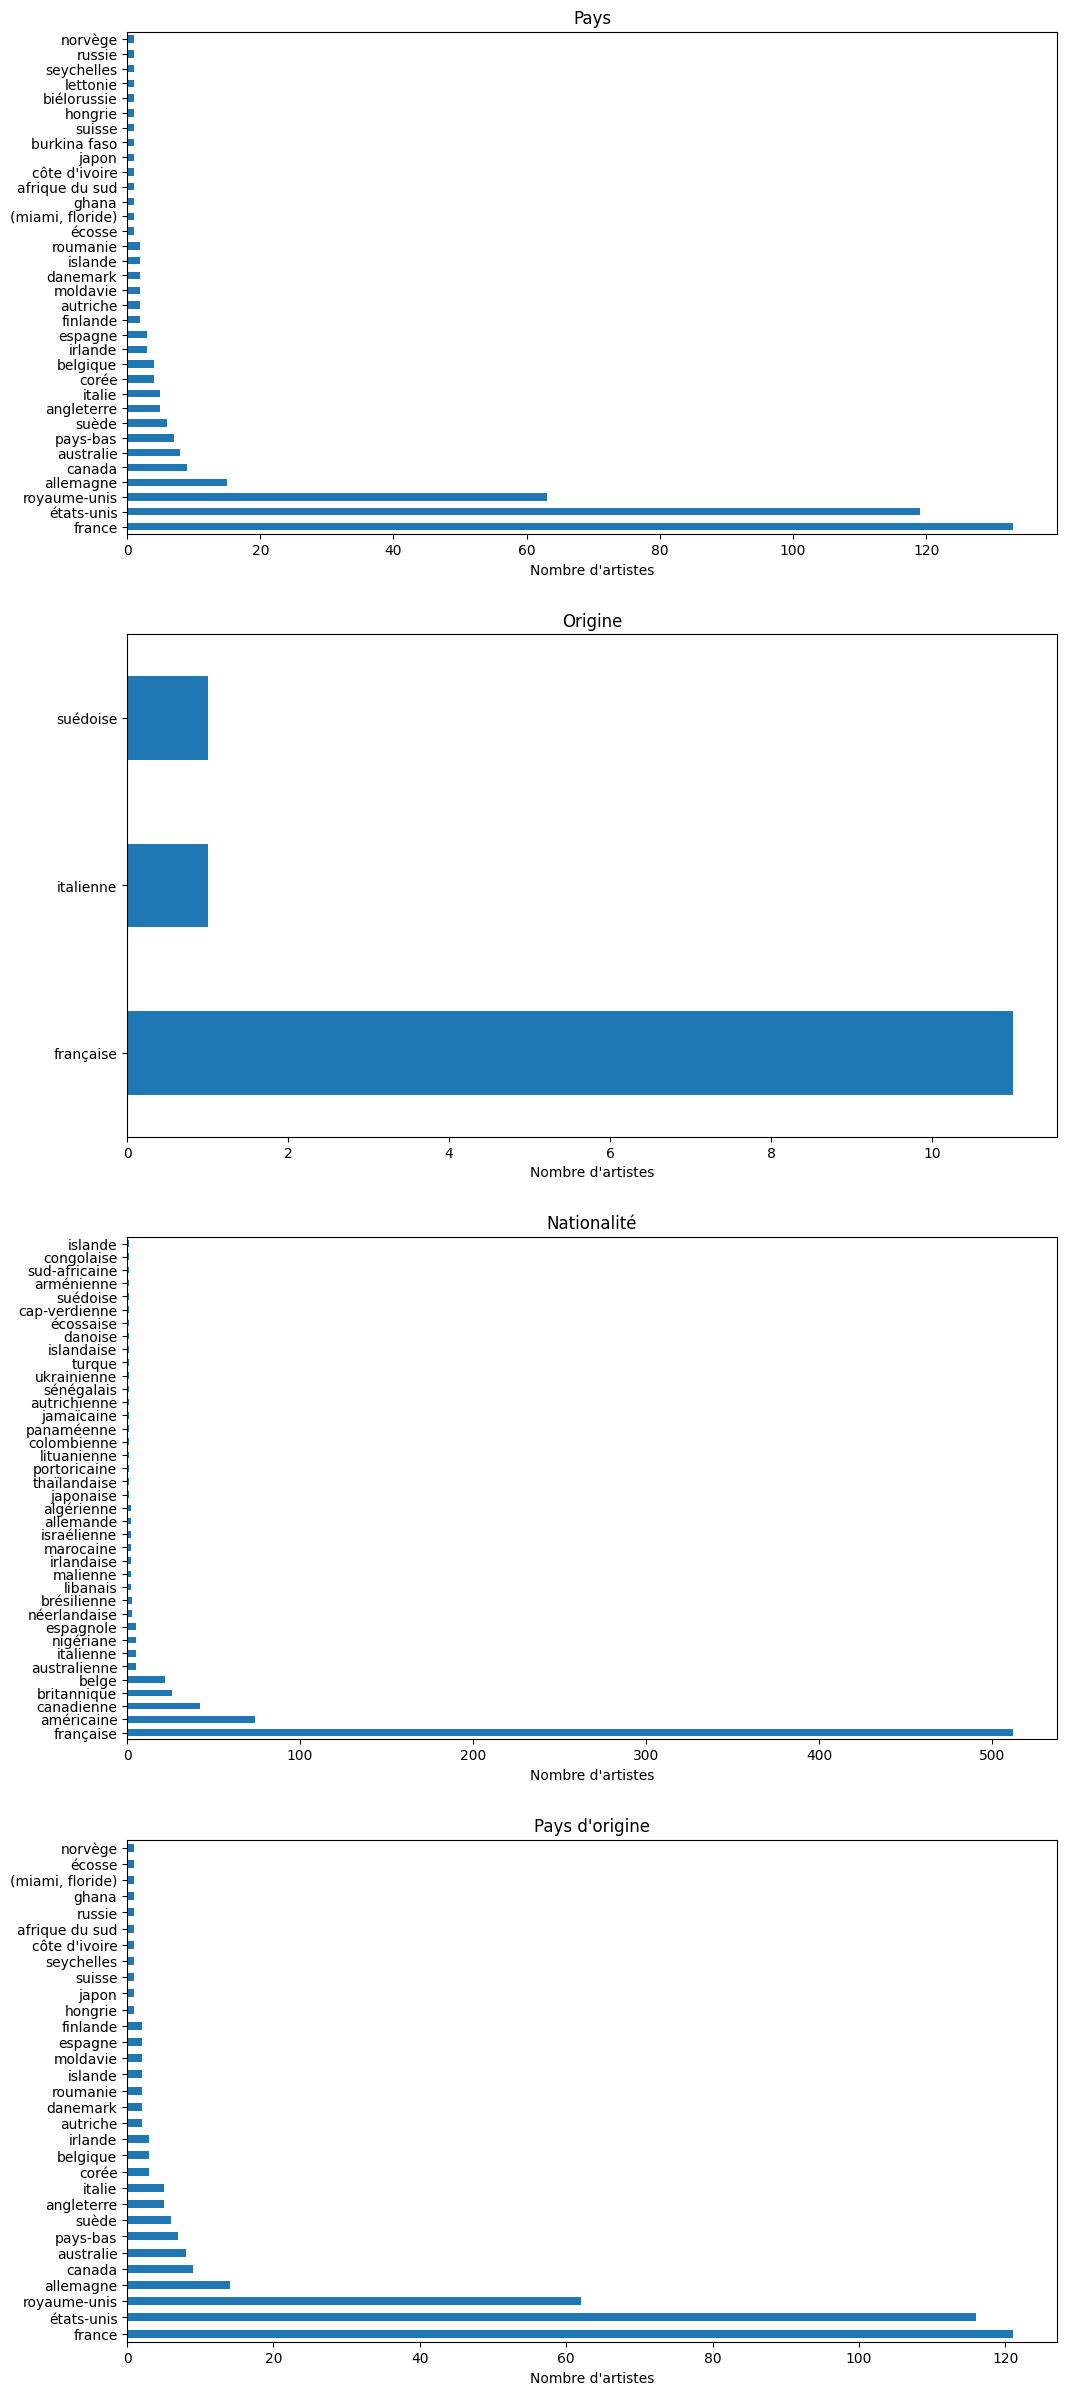

In [38]:
fig, ax = plt.subplots(4, 1, figsize=(12, 30))
for axi, col in zip(ax.flatten(), ["Pays", "Origine", "Nationalité", "Pays d'origine"]):
    artist[col].value_counts().plot.barh(ax=axi, title=col)
    axi.set(xlabel="Nombre d'artistes")

In [29]:
for col in ["Pays", "Origine", "Nationalité", "Pays d'origine"]:
    print("-" * 50)
    print(col.upper())
    print("-" * 50)
    print(artist[col].value_counts())

--------------------------------------------------
PAYS
--------------------------------------------------
france              133
états-unis          119
royaume-unis         63
allemagne            15
canada                9
australie             8
pays-bas              7
suède                 6
angleterre            5
italie                5
corée                 4
belgique              4
irlande               3
espagne               3
finlande              2
autriche              2
moldavie              2
danemark              2
islande               2
roumanie              2
écosse                1
(miami, floride)      1
ghana                 1
afrique du sud        1
côte d'ivoire         1
japon                 1
burkina faso          1
suisse                1
hongrie               1
biélorussie           1
lettonie              1
seychelles            1
russie                1
norvège               1
Name: Pays, dtype: int64
--------------------------------------------------
O

In [89]:
n = 100
artist[["Artist_wiki", "Naissance"]].sort_values('Naissance')[n-50:n]

,Artist_wiki,Naissance
Artist,,
Cheb Mami,Cheb Mami,11 juillet 1966 (56 ans)Saïda (Algérie)
Lil' Jump,Lil' Kim,"11 juillet 1974 (48 ans)Brooklyn, New York, É..."
Peter Cincotti,Peter Cincotti,"11 juillet 1983 (39 ans)New York, État de New ..."
Alessia Cara,Alessia Cara,"11 juillet 1996 (26 ans)Brampton, Ontario, Ca..."
Hugh Laurie,Hugh Laurie,11 juin 1959 (63 ans)Blackbird Leys (en) (Oxfo...
Mister Sun,Kim Hee-sun,"11 juin 1977 (45 ans)Daegu, Corée du Sud"
Kodak Black,Kodak Black,"11 juin 1997 (25 ans)Pompano Beach, Floride Ét..."
Jorja Smith,Jorja Smith,11 juin 1997 (25 ans)Walsall (Royaume-Uni)
Pierre Gambini,Pierre Coran,11 mai 1934Saint-Denis


In [90]:
artist["Naissance"].str.split(" ", expand=True)

,0,1,2,3,4,5,6,7,8,9,10
Artist,,,,,,,,,,,
LP,18,mars,1981,(41 ans)Long,"Island,",État,de,New,"York,",,États-Unis
Les Enfants Du Pays,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lynda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Iv My People,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mickael Turtle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Andy Williams,3,décembre,1927Wall,"Lake,","(Iowa,",États-Unis),None,None,None,None,None
Duffy,23,juin,1984,(38 ans),"Bangor,",pays,de,Galles,None,None,None
Martial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Commune france

In [91]:
region = pd.read_csv("../france/departements-france.csv")
commune = pd.read_csv("../france/communes-departement-region.csv")
departement = pd.read_csv("../france/departements-france.csv")
nb_habitant = pd.read_csv("../france/nb_habitant.csv")

commune = commune.merge(nb_habitant[["Ville", "nb_habitant"]], left_on="nom_commune", right_on="Ville")
commune["nb_habitant"] = commune["nb_habitant"].str.replace(" ", "")
commune["nb_habitant"] = commune["nb_habitant"].astype("int")

In [92]:
commune.head(3)

,code_commune_INSEE,nom_commune_postal,code_postal,libelle_acheminement,ligne_5,latitude,longitude,code_commune,article,nom_commune,nom_commune_complet,code_departement,nom_departement,code_region,nom_region,Ville,nb_habitant
0,1004,AMBERIEU EN BUGEY,1500,AMBERIEU EN BUGEY,NaN,45.960848,5.372926,4.0,NaN,Ambérieu-en-Bugey,Ambérieu-en-Bugey,1,Ain,84.0,Auvergne-Rhône-Alpes,Ambérieu-en-Bugey,14134
1,1005,AMBERIEUX EN DOMBES,1330,AMBERIEUX EN DOMBES,NaN,45.996180,4.912273,5.0,NaN,Ambérieux-en-Dombes,Ambérieux-en-Dombes,1,Ain,84.0,Auvergne-Rhône-Alpes,Ambérieux-en-Dombes,1751
2,1006,AMBLEON,1300,AMBLEON,NaN,45.749499,5.594320,6.0,NaN,Ambléon,Ambléon,1,Ain,84.0,Auvergne-Rhône-Alpes,Ambléon,112


In [93]:
artist["Region"] = " "
for r in tqdm(region["nom_region"]):
    artist.loc[artist["Naissance"].str.lower().str.contains(r.lower(), na=False), "Region"] = r

100%|██████████| 101/101 [00:00<00:00, 442.74it/s]


In [94]:
artist["Commune"] = " "
for c in tqdm(commune[commune["nb_habitant"] > 2000]["nom_commune"]):
    artist.loc[artist["Naissance"].str.lower().str.contains(c.lower(), na=False), "Commune"] = c

100%|██████████| 6980/6980 [00:14<00:00, 471.39it/s]


In [95]:
artist["Departement"] = " "
for d in tqdm(departement["nom_departement"]):
    artist.loc[artist["Naissance"].str.lower().str.contains(d.lower(), na=False), "Departement"] = d

100%|██████████| 101/101 [00:00<00:00, 470.22it/s]


In [96]:
artist["Departement"].value_counts()

                       2026
Paris                    69
Ain                      27
Rhône                    13
Seine-Saint-Denis        12
Hauts-de-Seine           12
Nord                     11
Val-d'Oise                9
Yvelines                  7
Val-de-Marne              7
Guadeloupe                6
Essonne                   5
Seine-et-Marne            4
Guyane                    3
Loire                     3
Var                       3
Alpes-Maritimes           3
Gard                      3
Seine-Maritime            3
Loiret                    3
Martinique                2
Aude                      2
Oise                      2
Aisne                     2
Eure                      2
Somme                     2
Moselle                   2
Finistère                 2
Sarthe                    2
Marne                     2
Pas-de-Calais             1
Tarn-et-Garonne           1
La Réunion                1
Vosges                    1
Gironde                   1
Haut-Rhin           

In [97]:
artist[artist["Departement"] == "Rhône"][:50]

,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary,distance,distance_norm,Missing,Region,Commune,Departement
Artist,,,,,,,,,,,,,
Soso Maness,Soso Maness,"21 mars 1987 (35 ans)Marseille, Bouches-du-Rhône",NaN,NaN,NaN,NaN,NaN,0,0.000000,False,,,Rhône
Mickaël Miro,Mickaël Miro,"8 novembre 1978 (44 ans)Villeurbanne, Rhône( F...",NaN,NaN,française,NaN,"Mickaël Cohen, dit Mickaël Miro, né le 8 novem...",0,0.000000,False,,Eu,Rhône
Woodkid,Woodkid,16 mars 1983 (39 ans)Tassin-la-Demi-LuneRhône-...,NaN,NaN,française,NaN,"Yoann Lemoine, également dit Woodkid, est un a...",0,0.000000,False,,Tassin-la-Demi-Lune,Rhône
Louisy Joseph,Louisy Joseph,14 avril 1978 (44 ans)Vénissieux (Rhône),NaN,NaN,française,NaN,"Louisy Joseph, de son vrai nom Lydy Louisy-Jos...",0,0.000000,False,,Eu,Rhône
Coralie Clément,Coralie Clément (chanteuse),1er septembre 1978 (44 ans)Villefranche-sur-Sa...,NaN,NaN,française,NaN,"Coralie Clément, née Coralie Biolay le 1er sep...",12,0.800000,False,,Villefranche-sur-Saône,Rhône
Imany,Imany,"5 avril 1979 (43 ans)Martigues, Bouches-du-Rhô...",NaN,NaN,française,NaN,"Nadia Mladjao, dite Imany, est une chanteuse, ...",0,0.000000,False,,Martigues,Rhône
L'algerino,L'Algérino,"2 mai 1981 (41 ans)Marseille, Bouches-du-Rhône...",NaN,NaN,NaN,NaN,NaN,1,0.100000,False,,,Rhône
Naps,Naps,"15 février 1986 ou 27 juillet 1991Marseille, B...",NaN,NaN,NaN,NaN,NaN,0,0.000000,False,,,Rhône
Soprano,Soprano (rappeur),14 janvier 1979 (43 ans)Marseille (Bouches-du-...,NaN,NaN,française,NaN,"Soprano, pseudonyme de Saïd M'Roumbaba, né le...",10,1.428571,False,,,Rhône


In [98]:
chart[chart["Artist"] == "Orelsan"]

,Artist,Music,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary,summary
79,Orelsan,Suicide Social,Orelsan,1er août 1982 (40 ans)Alençon (France),NaN,NaN,français,NaN,NaN,"Aurélien Cotentin, dit Orelsan (/ɔʁɛlˈsan/), e..."
68,Orelsan,Ils Sont Cools,Orelsan,1er août 1982 (40 ans)Alençon (France),NaN,NaN,français,NaN,NaN,"Aurélien Cotentin, dit Orelsan (/ɔʁɛlˈsan/), e..."
12,Orelsan,La Terre Est Ronde,Orelsan,1er août 1982 (40 ans)Alençon (France),NaN,NaN,français,NaN,NaN,"Aurélien Cotentin, dit Orelsan (/ɔʁɛlˈsan/), e..."
22,Orelsan,Tout Va Bien,Orelsan,1er août 1982 (40 ans)Alençon (France),NaN,NaN,français,NaN,NaN,"Aurélien Cotentin, dit Orelsan (/ɔʁɛlˈsan/), e..."
42,Orelsan,Basique,Orelsan,1er août 1982 (40 ans)Alençon (France),NaN,NaN,français,NaN,NaN,"Aurélien Cotentin, dit Orelsan (/ɔʁɛlˈsan/), e..."
87,Orelsan,Défaite De Famille,Orelsan,1er août 1982 (40 ans)Alençon (France),NaN,NaN,français,NaN,NaN,"Aurélien Cotentin, dit Orelsan (/ɔʁɛlˈsan/), e..."
75,Orelsan,La Pluie,Orelsan,1er août 1982 (40 ans)Alençon (France),NaN,NaN,français,NaN,NaN,"Aurélien Cotentin, dit Orelsan (/ɔʁɛlˈsan/), e..."
6,Orelsan,Rãªves Bizarres,Orelsan,1er août 1982 (40 ans)Alençon (France),NaN,NaN,français,NaN,NaN,"Aurélien Cotentin, dit Orelsan (/ɔʁɛlˈsan/), e..."
28,Orelsan,"La Famille, La Famille",Orelsan,1er août 1982 (40 ans)Alençon (France),NaN,NaN,français,NaN,NaN,"Aurélien Cotentin, dit Orelsan (/ɔʁɛlˈsan/), e..."
31,Orelsan,Mes Grands-parents,Orelsan,1er août 1982 (40 ans)Alençon (France),NaN,NaN,français,NaN,NaN,"Aurélien Cotentin, dit Orelsan (/ɔʁɛlˈsan/), e..."


In [99]:
chart.groupby("Artist")["Music"].count().sort_values(ascending=False)[0:50]

Artist
Jul                    102
Booba                   49
Ninho                   48
David Guetta            46
Sch                     43
Rihanna                 40
Maitre Gims             39
Kaaris                  35
Timal                   34
Orelsan                 34
Johnny Hallyday         33
Dadju                   32
Soprano                 31
Leto                    30
Mylène Farmer           28
Lady GaGa               27
Aya Nakamura            27
M. Pokora               26
Damso                   26
Djadja et Dinaz         25
PNL                     25
Madonna                 24
Katy Perry              23
Drake                   23
Niska                   22
Black M                 22
Lacrim                  22
P!nk                    22
The Black Eyed Peas     21
Freeze Corleone         21
Ed Sheeran              20
Calvin Harris           20
Beyoncé                 20
Nekfeu                  20
Tayc                    20
Lana Del Rey            20
Stromae              